In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [4]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# select domain
mask_lon = (ds.XLONG >= minlon) & (ds.XLONG <= maxlon)
mask_lat = (ds.XLAT >= minlat) & (ds.XLAT <= maxlat)
ds = ds.where(mask_lon & mask_lat, drop=True)

In [5]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

## viz. 1

In [6]:
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask
T2 = ds['T2'].groupby('XTIME.day').mean().values*seamask

LHF_file = '/dagobah/WRF_EUREC4A/COARE35/Fluxes/FEB/01/LHF_daily_coare35_d02_2020-02'
ds_tmp = xr.open_dataset(LHF_file) # gia fatto ritaglio lonlat
LHF_coare = ds_tmp['LHF'].values*seamask
del ds_tmp

SHF_file = '/dagobah/WRF_EUREC4A/COARE35/Fluxes/FEB/01/SHF_daily_coare35_d02_2020-02'
ds_tmp = xr.open_dataset(SHF_file) # gia fatto ritaglio lonlat
SHF_coare = ds_tmp['SHF'].values*seamask
del ds_tmp

In [7]:
s = 'inf'

dsst_day = np.zeros(sst_day.shape)
dT2 = dsst_day.copy()
dLHF = dsst_day.copy()
dSHF = dsst_day.copy()

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    T2_ave = gm.nan_gaussian_filter(T2[t],s)                             
    dT2[t] = T2[t] - T2_ave
    
    lhf_ave = gm.nan_gaussian_filter(LHF_coare[t],s)                             
    dLHF[t] = LHF_coare[t] - lhf_ave
    
    shf_ave = gm.nan_gaussian_filter(SHF_coare[t],s)                             
    dSHF[t] = SHF_coare[t] - shf_ave
    

0
10
20


In [8]:
fourier_large = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_forced_LARGE.npy')
fou_01 = np.ones_like(fourier_large)
fou_01[fourier_large != 1.] = 0

/venus/tesi_ale/plots_forced_EU/maps_forced_article_lowQuality.png


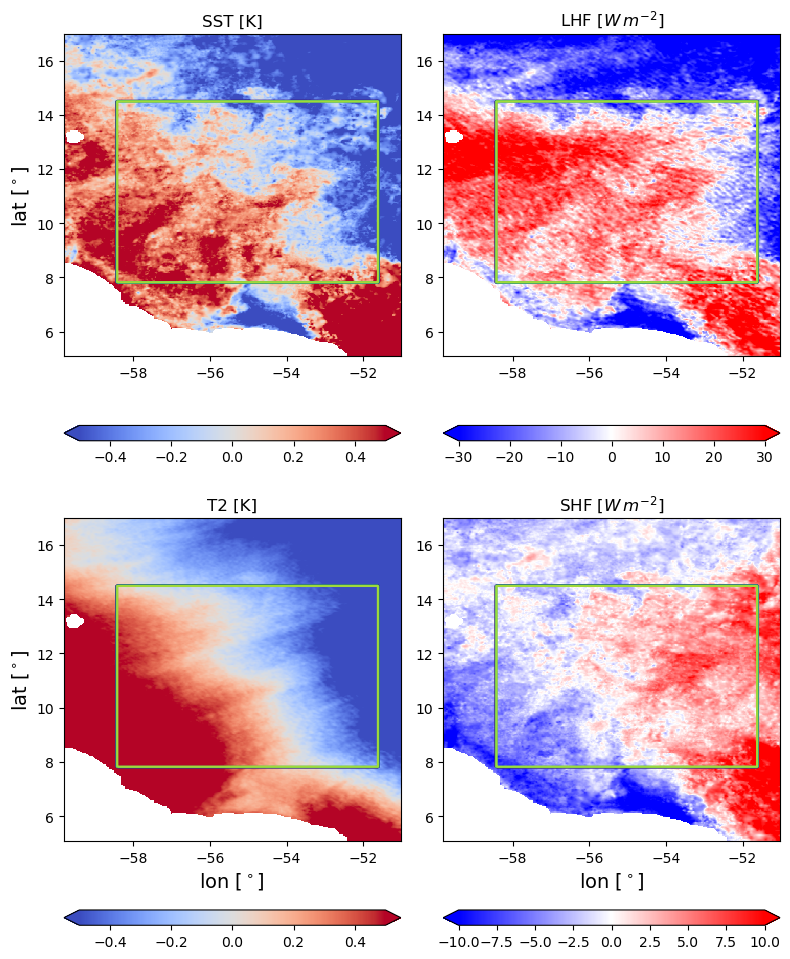

In [24]:
day = int(4)
fig, ax = plt.subplots(2,2, figsize=(8,10))
# fig.suptitle(f'High pass anomalies, std. dev. = {s}')

mesh_sst = ax[0, 0].pcolormesh(lon, lat, (dsst_day[day]), cmap='coolwarm', vmin=-0.5, vmax=0.5  )
ax[0,0].contour(lon, lat, fou_01, levs=[0.9, 1.1])
ax[0, 0].set_ylabel('lat [$^\circ$]', fontsize=14)
ax[0, 0].set_title('SST [K]')
cbar_anoms = plt.colorbar(mesh_sst, ax=ax[0,0], location='bottom', extend='both', pad=0.15, shrink=1)
# cbar_anoms.set_label('[K]', fontsize=14)


mesh_anoms_t2= ax[1,0].pcolormesh(lon, lat, (dT2[day]), cmap='coolwarm', vmin=-0.5, vmax=0.5  )
ax[1,0].contour(lon, lat, fou_01, levs=[0.9, 1.1])
ax[1,0].set_title('T2 [K]')
ax[1,0].set_ylabel(r'lat [$^\circ$]', fontsize=14)
ax[1,0].set_xlabel(r'lon [$^\circ$]', fontsize=14)

cbar_anoms = plt.colorbar(mesh_anoms_t2, ax=ax[1,0], location='bottom', extend='both', pad=0.15, shrink=1)
# cbar_anoms.set_label('[K]', fontsize=14)



mesh_anoms_lhf = ax[0,1].pcolormesh(lon, lat, (dLHF[day]), cmap='bwr', vmin=-30., vmax=30.)
ax[0,1].contour(lon, lat, fou_01, levs=[0.9, 1.1])
ax[0,1].set_title(r'LHF [$W\,m^{-2}$]')
# ax[0,1].set_ylabel('lat [$^\circ$]')
cbar_anoms = plt.colorbar(mesh_anoms_lhf, ax=ax[0,1], location='bottom', extend='both', shrink=1, pad=0.15)
# cbar_anoms.set_label(r'[$W\,m^{-2}$]', fontsize=14)


mesh_anoms_shf=ax[1,1].pcolormesh(lon, lat, (dSHF[day]), cmap='bwr', vmin=-10., vmax=10.  )
ax[1,1].contour(lon, lat, fou_01, levs=[0.9, 1.1])
ax[1,1].set_title(r'SHF [$W\,m^{-2}$]')
# ax[1,1].set_ylabel('lat [$^\circ$]')
ax[1,1].set_xlabel(r'lon [$^\circ$]', fontsize=14)


cbar_anoms = plt.colorbar(mesh_anoms_shf, ax=ax[1,1], location='bottom', extend='both', pad=0.15, shrink=1)
# cbar_anoms.set_label(r'[$W\,m^{-2}$]', fontsize=14)


plt.tight_layout()


base_path = '/venus/tesi_ale/plots_forced_EU/'
filename = base_path + 'maps_forced_article_lowQuality.png'
print(filename)
# plt.savefig(filename)

# viz. 2

In [6]:
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask
T2 = ds['T2'].groupby('XTIME.day').mean().values*seamask
q2 = ds['Q2'].groupby('XTIME.day').mean().values*seamask
pblh = ds['PBLH'].groupby('XTIME.day').mean().values*seamask

In [7]:
s = 65   # 'inf'

dsst_day = np.zeros(sst_day.shape)
dT2 = dsst_day.copy()
dq2 = dsst_day.copy()
dpblh = dsst_day.copy()


sst_ave, T2_ave, q2_ave, pblh_ave = \
np.zeros(sst_day.shape), np.zeros(sst_day.shape), np.zeros(sst_day.shape), np.zeros(sst_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave[t] = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave[t]
    
    T2_ave[t] = gm.nan_gaussian_filter(T2[t],s)                             
    dT2[t] = T2[t] - T2_ave[t]
    
    q2_ave[t] = gm.nan_gaussian_filter(q2[t],s)                             
    dq2[t] = q2[t] - q2_ave[t]
    
    pblh_ave[t] = gm.nan_gaussian_filter(pblh[t],s)                             
    dpblh[t] = pblh[t] - pblh_ave[t]

0
10
20


In [8]:
import regression

In [62]:
anomalies = False

x = dsst_day if anomalies else sst_ave       

y = dT2 if anomalies else T2_ave        

n_T2_sst, slope_T2_sst, intercept_T2_sst, cor_pearson_T2_sst, cor_spear_T2_sst, p_val_pearson_T2_sst, p_val_spear_T2_sst,\
r_square_T2_sst, rmse_T2_sst = regression.MY_point_regr(x,y)



y = dq2 if anomalies else q2_ave             

n_q2_sst, slope_q2_sst, intercept_q2_sst, cor_pearson_q2_sst, cor_spear_q2_sst, p_val_pearson_q2_sst, p_val_spear_q2_sst,\
r_square_q2_sst, rmse_q2_sst = regression.MY_point_regr(x,y)



y = dpblh if anomalies else  pblh_ave              

n_H_sst, slope_H_sst, intercept_H_sst, cor_pearson_H_sst, cor_spear_H_sst, p_val_pearson_H_sst, p_val_spear_H_sst,\
r_square_H_sst, rmse_H_sst = regression.MY_point_regr(x,y)



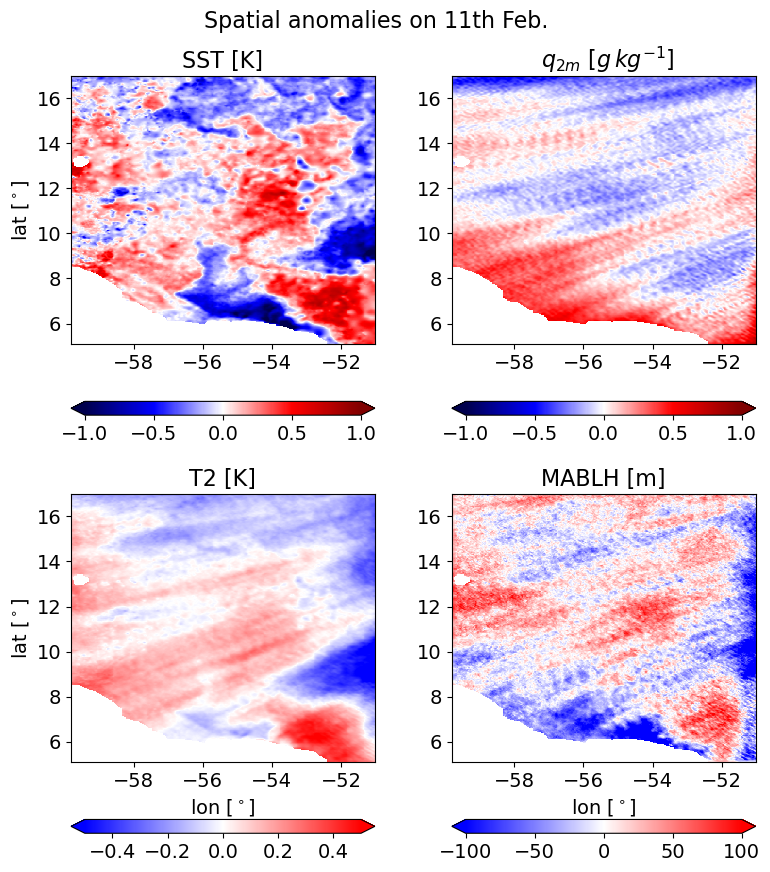

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(8, 9))
# (ax[0,0], ax[0,1], ax[1,0], ax[1,1]) = ax
plt.suptitle(f'Spatial anomalies on 11th Feb.', fontsize=16)
day = int(10)

mask_here = np.where(sst_day[day]/sst_day[day] != 1, np.nan, 1)

#######################################################
# ax[0,0].pcolormesh(lon, lat, sst_day[day]*mask_here, alpha=0.5, vmin=298, vmax=301) #, cmap='coolwarm')
sst_map = ax[0,0].pcolormesh(lon, lat, dsst_day[day], vmin=-1, vmax=1, cmap='seismic')

cbar1 = plt.colorbar(sst_map, ax=ax[0,0], extend='both', location='bottom')
cbar1.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
# cbar1.set_label(r'[$K$]', fontsize=14)  # Set fontsize for colorbar label
# ax[0,0].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[0,0].set_ylabel('lat [$^\circ$]', fontsize=14)
ax[0,0].set_title(r"SST [K]", fontsize=16)


#######################################################
# ax[0,1].pcolormesh(lon, lat, T2_day[day]*mask_here, alpha=0.5, vmin=298, vmax=301)
q2_map = ax[0,1].pcolormesh(lon, lat, dq2[day]*1e3, vmin=-1, vmax=1, cmap='seismic')
cbar2 = plt.colorbar(q2_map, ax=ax[0,1], extend='both', location='bottom')
cbar2.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
# cbar2.set_label(r' [$K$]', fontsize=14)  # Set fontsize for colorbar label
# ax[0,1].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[0,1].set_title(r" $q_{2m}$ [$g\,kg^{-1}$]", fontsize=16)


###############################################
# ax[1,0].pcolormesh(lon, lat, q2_day[day]*mask_here*1e3, alpha=0.5)
t2_map = ax[1,0].pcolormesh(lon, lat, dT2[day], vmin=-0.5, vmax=0.5, cmap='bwr')
cbar3 = plt.colorbar(t2_map, ax=ax[1,0], extend='both', location='bottom', pad=0.15)
cbar3.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
# cbar3.set_label(r"[$g\,kg^{-1}$]", fontsize=14)  # Set fontsize for colorbar label
ax[1,0].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[1,0].set_ylabel('lat [$^\circ$]', fontsize=14)
ax[1,0].set_title(r"T2 [K]", fontsize=16)


###############################################
# ax[1,1].pcolormesh(lon, lat, q2_day[day]*mask_here*1e3, alpha=0.5)
pblh_map = ax[1,1].pcolormesh(lon, lat, dpblh[day], vmin=-100, vmax=100, cmap='bwr')
cbar3 = plt.colorbar(pblh_map, ax=ax[1,1], extend='both', location='bottom', pad=0.15)
cbar3.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
# cbar3.set_label(r"[$g\,kg^{-1}$]", fontsize=14)  # Set fontsize for colorbar label
ax[1,1].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[1,1].set_title(r"MABLH [m]", fontsize=16)


# Set fontsize for tick labels
ax[0,0].tick_params(axis='both', which='major', labelsize=14)
ax[0,1].tick_params(axis='both', which='major', labelsize=14)
ax[1,0].tick_params(axis='both', which='major', labelsize=14)
ax[1,1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()



# plt.savefig('/venus/tesi_ale/plots_forced_EU/alternative_maps_article.png')

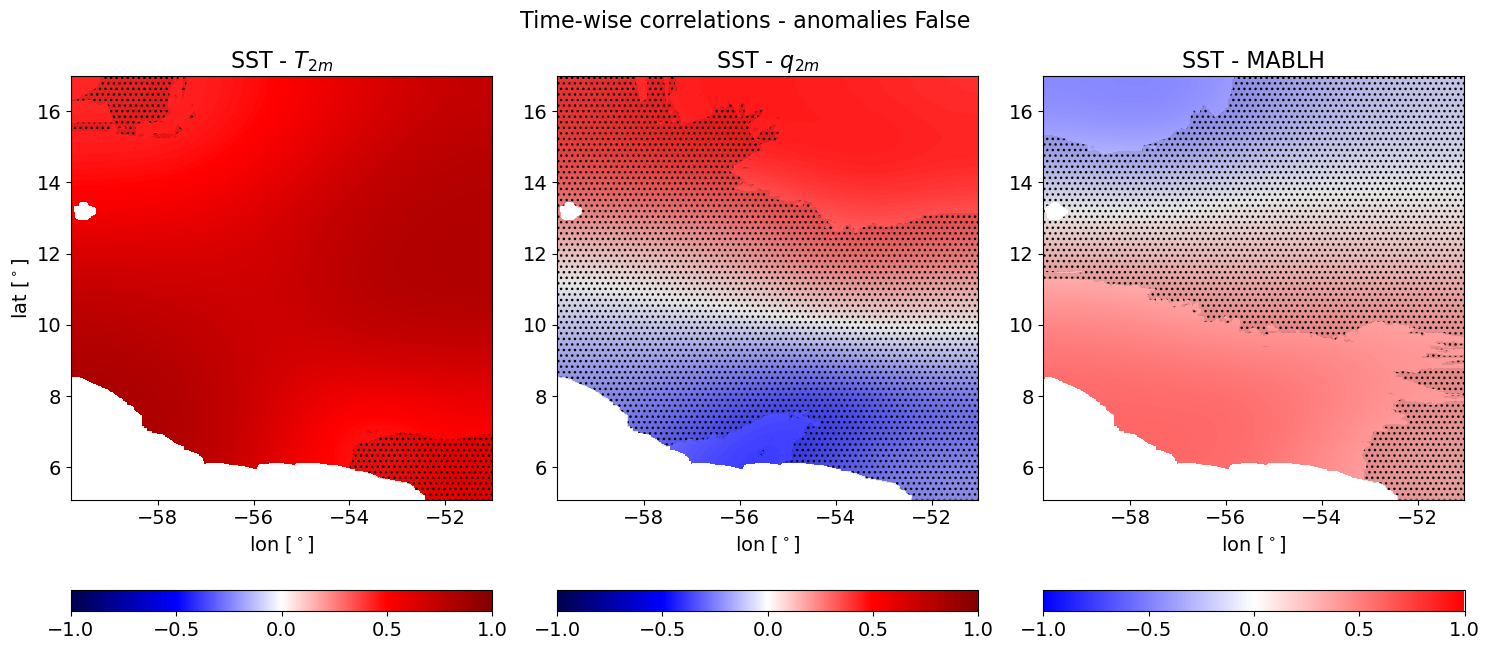

In [63]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
plt.suptitle(f'Time-wise correlations - anomalies {anomalies}', fontsize=16)
day = int(10)

mask_here = np.where(sst_day[day]/sst_day[day] != 1, np.nan, 1)

#######################################################
# ax1.pcolormesh(lon, lat, sst_day[day]*mask_here, alpha=0.5, vmin=298, vmax=301) #, cmap='coolwarm')
sst_map = ax1.pcolormesh(lon, lat, cor_pearson_T2_sst, vmin=-1, vmax=1, cmap='seismic')

cbar1 = plt.colorbar(sst_map, ax=ax1, label=r'', location='bottom', pad=0.15)
cbar1.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
# cbar1.set_label(r'[$K$]', fontsize=14)  # Set fontsize for colorbar label
ax1.set_xlabel('lon [$^\circ$]', fontsize=14)
ax1.set_ylabel('lat [$^\circ$]', fontsize=14)
ax1.set_title(r"SST - $T_{2m}$", fontsize=16)

# Hatching for p-values less than 0.05
dhatch_mask = np.zeros_like(cor_pearson_T2_sst)
dhatch_mask[p_val_spear_T2_sst > 0.05] = 1
cont1 = ax1.contourf(lon, lat, dhatch_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.1)




#######################################################
# ax2.pcolormesh(lon, lat, T2_day[day]*mask_here, alpha=0.5, vmin=298, vmax=301)
t2_map = ax2.pcolormesh(lon, lat, cor_pearson_q2_sst, vmin=-1, vmax=1, cmap='seismic')
cbar2 = plt.colorbar(t2_map, ax=ax2, label=r'', location='bottom', pad=0.15)
cbar2.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
# cbar2.set_label(r' [$K$]', fontsize=14)  # Set fontsize for colorbar label
ax2.set_xlabel('lon [$^\circ$]', fontsize=14)
ax2.set_title(r"SST - $q_{2m}$", fontsize=16)

# Hatching for p-values less than 0.05
dhatch_mask = np.zeros_like(cor_pearson_q2_sst)
dhatch_mask[p_val_spear_q2_sst > 0.05] = 1
cont2 = ax2.contourf(lon, lat, dhatch_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.1)




###############################################
# ax3.pcolormesh(lon, lat, q2_day[day]*mask_here*1e3, alpha=0.5)
q2_map = ax3.pcolormesh(lon, lat, cor_pearson_H_sst, vmin=-1, vmax=1, cmap='bwr')
cbar3 = plt.colorbar(q2_map, ax=ax3, label=r'', location='bottom', pad=0.15)
cbar3.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
# cbar3.set_label(r"[$g\,kg^{-1}$]", fontsize=14)  # Set fontsize for colorbar label
ax3.set_xlabel('lon [$^\circ$]', fontsize=14)
ax3.set_title(r"SST - MABLH", fontsize=16)

# Hatching for p-values less than 0.05
dhatch_mask = np.zeros_like(cor_pearson_H_sst)
dhatch_mask[p_val_spear_H_sst > 0.05] = 1
cont3 = ax3.contourf(lon, lat, dhatch_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.1)




# Set fontsize for tick labels
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)




plt.tight_layout()

# plt.savefig('/venus/tesi_ale/img_EU/plots_MeteoXChange/anoms_maps.pdf')


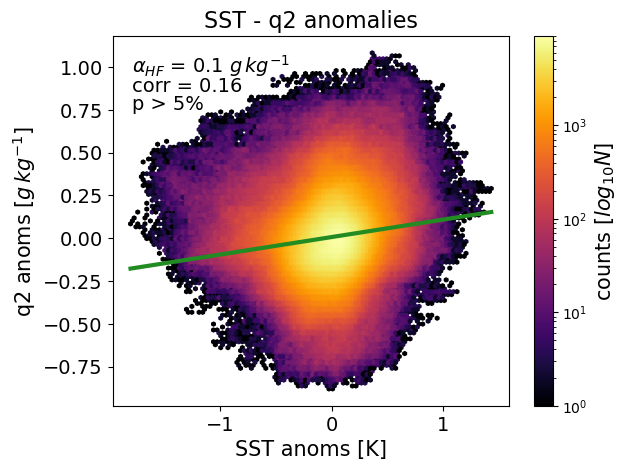

In [76]:
##### FITTING #####


day = int(2)
dsst = True


if not dsst:
    L = 198
    nskip = int(L/3)
    nt = int(1)
    # nbin = 50

    x =  (sst_ave-273.15).copy()     #[:, 100:125, 125:175]
    y =  (q2_ave.copy()*1e3)     #[:, 100:125, 125:175]
    
#     xx = pdist_sst-273.15
#     yy = pdist_LH
    
    fit, corcoe, p_value, p_value_cannelli, sigmas_sst_lh = slopes_r_p_mix(x, y, nt, nskip)
    title=' SST - q2 large scale'
    xlabel='SST [˚C]'
    ylabel=r'q2 [$g\,kg^{-1}$]'
    
else:
    L = 80
    nskip = int(L/3)
    nt = int(1)
    
    x = dsst_day.copy() 
    y = dq2.copy()*1e3 #dLH.copy()
    
#     xx = pdist_x
#     yy = pdist_dLH
    
    fit, corcoe, p_value, p_value_cannelli, sigmas_dsst_dlh = slopes_r_p_mix(x, y, nt, nskip)
    title= "SST - q2 anomalies"
    xlabel='SST anoms [K]'
    ylabel=r'q2 anoms [$g\,kg^{-1}$]'
#     miny = -100 ; maxy = 75
#     minx = -1.5 ; maxx = 1
    
pos = [0.05, 0.9]
# fig = density_hexbin(x[:,::nskip,::nskip],y[:,::nskip,::nskip],plot_fit=True,fit=fit,corcoe=corcoe,grdsz=100,\
#                      title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos, slope_units=" $g\,kg^{-1}\,K^{-1}$")
fig = density_hexbin(x,y,plot_fit=True,fit=fit,corcoe=corcoe,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos, slope_units=" $g\,kg^{-1}$")

plt.tick_params(axis='x', labelsize=14) 
plt.tick_params(axis='y', labelsize=14)


# if dsst:
#     plt.vlines(0, ymin=miny, ymax=maxy, color='k', linewidth=1, linestyle='--')
#     plt.hlines(0, xmin=minx, xmax=maxx, color='k', linewidth=1, linestyle='--')
    
if p_value_cannelli < 0.05:
    plt.annotate('p < 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=14, color='k')
else:
    plt.annotate('p > 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=14, color='k')

    

# path_img = '/venus/tesi_ale/plots_forced_EU/ThermContr_LHF_only/' 
# filename = path_img + 'scatterFIT_dsst_dLHF.png' if dsst else path_img + 'scatterFIT_sst_LHF.png'
# # plt.savefig(filename)
# print(filename)
# del filename